# **Project SPOTTED: State-sponsored Troll Tweets Detection**
---

**<u>_Objective:_</u>** We fine-tune a pretrained BERTModel, to predict if a tweet is made by an information operative (state-sponsored troll) or by a verified Twitter account. Our purpose is to increase the efficiency of identifying, and disrupting state-sponsored disinformation campaigns for the defense and intelligence community.



---
# **Modelling**
---

This section wil summarize the notebooks in the Model Selection folder.

We have chosen to fine-tune a pretrained BERT Model called **BertForSeqeuenceClassification**. BERT stands for _Bidirectional Encoding From Transformers_, and is a state-of-the-art NLP model. BERT was developed by Google AI Language in 2018, and is considered as a swiss army knive for majority of NLP tasks. Typically, one requires separate models for different NLP tasks. But one can accomplish most of these with BERT. This is possible becasue BERT is trained on a very large dataset - Wikipedia (about 2.5 billion words) and Google's BookCorpus (about 800M words). It took Google 4 days of continuous training on custom TPUs to achieve this. BERT works by masking certain words, and using the words to the either side (hence, birectional!) of the mask to guess the masked word. Lastly, BERT uses a Transformer architecture to learn context and relationship between words. It it these combination that makes BERT such a powerful deep learning NLP model.

To use BERT model practically is easy because it is integrated with PyTorch and Tensorflow. This also allow to leverage on accelerated hardware aided by GPU to speed up calculations. In the Model Selection notebook for BERT, we trained the BERTModel with Google Colab GPU runtime.

For this main notebook, we will load the trained SPOTTED model, and use it to predict unseen tweets.

Those interested to learn more about BERT should visit the link: https://huggingface.co/blog/bert-101.

We will setup some configurations for the Google Colab, read the datasets and load the trained model to make predictions

## Setting up Environment for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change the working directory
%cd '/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/1 Project SPOTTED/2 Main'

/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/1 Project SPOTTED/2 Main


In [3]:
# Set up and download various dependencies - also suppress the outputs
%%capture
!pip3 install bertopic
!pip3 install datasets
!pip3 install evaluate
!pip3 install fastBPE sacremoses subword_nmt sentencepiece
!pip3 install demoji
!pip3 install torchvision
!pip3 install accelerate -U

## Setting Directory Paths in Google Colab

In [4]:
# specifying paths for Google Colab
import os
cur_dir = os.getcwd()
path    = cur_dir  #+ '/1 Project SPOTTED/2 Main'

utility_path = path + '/5_Utilities'
print(utility_path)

train_path   = path + '/1_Data/SPOTTED_test_dataset.csv'
predict_path = path + '/1_Data/SPOTTED_validation_dataset.csv'
fv_path      = path + '/4_Notebooks/2_Model_Selection/feature vectors/features_vector_bert.pt'
model_path   = path + '/4_Notebooks/2_Model_Selection/BertForSequenceClassification/checkpoint-1500'
viz_path     = path + '/4_Notebooks/3_Main/plots'

model_path

/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/1 Project SPOTTED/2 Main/5 utilities


'/content/drive/MyDrive/Data Science and Analytics Portfolio/2 Projects/1 Project SPOTTED/2 Main/4 notebooks/2 model selection/BertForSequenceClassification/checkpoint-1500'

In [5]:
# import modules and dependencies
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as mpp
import re
import nltk
import torch
import time
import sys
import demoji

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torch.optim import AdamW

# import the file with all the function definitions
sys.path.insert(0, utility_path)
from utility_functions import *

from bertopic import BERTopic
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict, Dataset

from nltk.cluster import KMeansClusterer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

from wordcloud import WordCloud
# settings for Matplotlib library
from matplotlib.pyplot import figure

pd.set_option('display.max_colwidth', None)

## Specifiying BERT Model and Tokenizer

We load the BERT tokenizer from the BERT-base-uncased model. The model does not distinguish words such as Text or text.

In [6]:
model_name = 'bert-base-uncased'
tokenizer  = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Read Test and Evaluation Datasets

We read the traning dataset, consisting of 150000 tweets and the 5000 unseen ones.

In [7]:
df_train = pd.read_csv(train_path).drop(columns = ['Unnamed: 0', 'hashtags'])
df_predict = pd.read_csv(predict_path).drop(columns = ['Unnamed: 0', 'hashtags'])

print('Length of train dataset : {}\nLength of evaluation dataset : {}'.format(len(df_train), len(df_predict)))

# let us change the datatype of the target column from float to integer
df_train = df_train.astype({'target' : 'int64'})
df_predict = df_predict.astype({'target' : 'int64'})

Length of train dataset : 150000
Length of evaluation dataset : 5000


In [8]:
df_predict['target'].value_counts().to_frame()

count
target       
0        2538
1        2462

## Data Cleaning

We perform some cleaning on the seen and unseen tweets - using the exact same text processing function on the test data in training BERT

In [9]:
df_train['clean_tweet_text']   = df_train['tweet_text'].apply(text_processing_bert)
df_predict['clean_tweet_text'] = df_predict['tweet_text'].apply(text_processing_bert)

df_predict.head(2)

tweet_text  \
0  RT @kodiak149: .@PetersonUtah deserves more followers \nFollow @PetersonUtah \nSupport @PetersonUtah \nElections matter \n#wtpBlue https://t.co…   
1                                                                                                      @unpuNISHAble_ @Desh3hunna like you'll avi's   

   target  \
0       1   
1       1   

                                                                                 clean_tweet_text  
0  rt : . deserves more followers \nfollow  \nsupport  \nelections matter \nwtpblue https://t.co…  
1                                                                            _  like you'll avi's

Next, we tokenize the clean tweets of the evaluation dataset

In [10]:
tweets_eval = list(df_predict['clean_tweet_text'])

X_eval_tokenized = tokenizer(tweets_eval, padding = True, truncation = True, max_length = 512)

X_eval_dataset = Dataset.from_dict({'input_ids' : X_eval_tokenized['input_ids']})

X_eval_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 5000
})

Here, we also assign another column of the feature vectors of each sentence to the train dataframe. This is in anticipation of the Kmeans clustering plot later


In [11]:
features_vector = torch.load(fv_path)
features_vector.numpy()

array([[-0.37975135,  0.4209657 ,  0.17822692, ..., -0.45024619,
         0.2521413 , -1.1288712 ],
       [-0.36047098,  0.41695333,  0.3343556 , ..., -0.474418  ,
         0.56389046, -0.74076104],
       [-0.31267634,  0.32727417,  0.37482268, ..., -0.37241983,
         0.36058196, -0.91934884],
       ...,
       [-0.29725802,  0.42033762,  0.37767896, ..., -0.38950834,
         0.49508968, -0.7912934 ],
       [-0.28778997,  0.44903085,  0.23536645, ..., -0.44510794,
         0.26985195, -0.9755546 ],
       [-0.36028552,  0.48626885,  0.03579707, ..., -0.4841972 ,
         0.3976073 , -0.89509076]], dtype=float32)

In [12]:
df_train['feature_vectors'] = [x for x in features_vector.numpy()]
df_train.head(1)

tweet_text  \
0  As of 5 June 2020, 12pm, we have preliminarily confirmed an additional 261 cases of COVID-19 infection in Singapore.  https://t.co/2RFMhrRkUw   

   target  \
0       0   

                                                                                                         clean_tweet_text  \
0  as of 5 june 2020, 12pm, we have preliminarily confirmed an additional 261 cases of covid-19 infection in singapore.     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                feature_vectors  
0  [-0.37975135, 0.4209657, 0.17822692, 0.6945978, -0.47414145, -0.28761476, 1.0795145, -0.15212901, -0.003983283, 0.52001727, 0.2075819, -0.54900336, -0.18995121, 0.684253, 0.35877228, 0.7148158, -0.33901766, 0.62849873, -0.19137353, 0.31598246, 0.544191, 0.01909353, 0.8536121, 0.08119907, -0.102806196, 0.43056577, -0.33986536, -1.3429903, -0.76572233, -0.07911352, -0.60219264, 0.6817547, 0.26841506, -0.24970639, 0.46072936, -0.49185455, -0.48435596, -0.02608502, 0.94735444, -0.04588864, -0.22672644, -0.4515655, 0.6234123, -0.5318944, -0.05481461, -0.63054377, -3.0412674, 0.23735182, -0.09747913, -1.2081938, -0.11595185, -0.40570834, 0.36923552, 0.28868508, -0.08060212, 0.6313394, 0.46245745, -1.1180725, 1.7996331, -0.32348955, -0.22821078, 0.5761322, -1.0227294, 0.24223231, -0.33968672, 1.0523144, 0.032194432, -0.11982052, -0.4263111, -0.12680778, 0.5390139, 0.51685655, 0.8381094, 0.7056102, 0.036362797, 0.06708326, -0.17048961, 1.128719, -0.56956017, -0.17108262, 0.08663157, -0.29811385, -0.010472795, -0.7995207, 0.37434748, 0.5376338, 0.66748065, -0.19180164, -0.5995369, 0.041043554, 0.858953, 0.27609268, 0.9155841, -0.011603555, -0.31068704, 0.39726648, 0.52059036, -0.034671977, 0.16574952, -0.3001554, ...]

---
# **Evaluate**
---

Now with the ingredients ready, we can now load the trained model for prediction.

Now, we load the trained BERT model - SPOTTED - from model selection

In [13]:
SPOTTED_model   = BertForSequenceClassification.from_pretrained(model_path, num_labels = 2)
SPOTTED_trainer = Trainer(SPOTTED_model)

In [14]:
raw_pred, _, _ = SPOTTED_trainer.predict(X_eval_dataset)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Now that we have loaded the model, we are ready to use it to predict the unseen tweets

In [15]:
df_predict['predicted target'] = np.argmax(raw_pred, axis = 1)
df_predict

tweet_text  \
0                                                                                                                                      RT @kodiak149: .@PetersonUtah deserves more followers \nFollow @PetersonUtah \nSupport @PetersonUtah \nElections matter \n#wtpBlue https://t.co…   
1                                                                                                                                                                                                                                          @unpuNISHAble_ @Desh3hunna like you'll avi's   
2                                                                                                                                      RT @MuslimIQ: Meanwhile millions of parents find it hard to cope that 1 in 6 kids go to bed hungry every night in America, &amp; the poverty th…   
3     .@TheRock put his #RedNotice co-stars @GalGadot and @VancityReynolds to the test in our first #MuseumFaceOff! 🎨 Follow @GoogleArts and find out which one of them can tell their Michelangelo from their Van Gogh.  https://t.co/UIoTCadGzz @NetflixFilm  https://t.co/ksE0Vg8zbR   
4                                                                                                                               Parents who could work from home tried to multitask their way through, often at the cost of their productivity, sanity or both  https://t.co/K0fzLY9kVe   
...                                                                                                                                                                                                                                                                                 ...   
4995                                                                                                                           Taiwanese Actress Bella Chang Had To Remove Her 1.5m-Long Large Intestine After Suffering From Chronic Constipation Since Young  https://t.co/m4KpjEhtYJ   
4996                                                                                                                                                                       RT @jason_compsonIV: The fate of all dictators is the same\nWish of their death by people\n#DownWithKhamenei   
4997                                                                                                @mark61167237 Hi Mark, you may wish to submit more information via the i-Witness portal at  https://t.co/1SxSjRqdGB. All information will be kept strictly confidential. Thank you.   
4998                                                                                                                                                                                                                                                                It is 22:48 UTC now   
4999                                                                                                                                                                                                                   Zarif in Kazakhstan to attend SCO summit https://t.co/LqaCVlbZK7   

      target  \
0          1   
1          1   
2          1   
3          0   
4          0   
...      ...   
4995       0   
4996       1   
4997       0   
4998       1   
4999       1   

                                                                                                                                                           clean_tweet_text  \
0                                                                            rt : . deserves more followers \nfollow  \nsupport  \nelections matter \nwtpblue https://t.co…   
1                                                                                                                                                      _  like you'll avi's   
2                                   rt : meanwhile millions of parents find it hard to cope that 1 in 6 kids go to bed hungry every night in america, &amp

In the subsequent cell we calculate the evaluation metrics of our model.

In [16]:
target_true    = df_predict['target']
target_predict = df_predict['predicted target']

auc_score = roc_auc_score(y_true = target_true, y_score = target_predict)
recall    = recall_score(y_true = target_true, y_pred = target_predict)
precision = precision_score(y_true = target_true, y_pred = target_predict)
f1        = f1_score(y_true = target_true, y_pred = target_predict)
accuracy  = accuracy_score(y_true = target_true, y_pred = target_predict)
confusion = confusion_matrix(y_true = target_true, y_pred = target_predict)

print('Confusion matrix:\n', confusion, '\n')
print(f'AUC Score : {auc_score}\n Recall : {recall}\n Precision : {precision}\n F1 Score : {f1}\n Final Accuracy Score : {accuracy}')

Confusion matrix:
 [[2430  108]
 [ 143 2319]] 

AUC Score : 0.949681974523394
 Recall : 0.9419171405361495
 Precision : 0.9555006180469716
 F1 Score : 0.9486602577214155
 Final Accuracy Score : 0.9498


We can also find the tweets in which the model predicted wrongly

In [17]:
wrong_predictions = df_predict[df_predict['target'] != df_predict['predicted target']]
print(len(wrong_predictions))
wrong_predictions.head(3)

251


tweet_text  \
6                                                                   A merry Christmas to all, and to all a good night!  https://t.co/FOcMKZM87x   
19  A heavily armed man was arrested on Thursday as he was caught entering a camp for Native American water protectors. https://t.co/r6Hl7OJSzB   
83                                         Polestar/Geely: electric vehicle maker offers challenge to Tesla  https://t.co/0R0KovS9Mk  | opinion   

    target  \
6        0   
19       1   
83       0   

                                                                                                        clean_tweet_text  \
6                                                                   a merry christmas to all, and to all a good night!     
19  a heavily armed man was arrested on thursday as he was caught entering a camp for native american water protectors.    
83                                                    polestar/geely: electric vehicle maker offers challenge to tesla     

    predicted target  
6                  1  
19                 0  
83                 1

## Data Visualizations

Now let us write some functions to plot some plots which will be useful. The first plot we can do is to plot the word frequency horizontal bar chart. But the weights of each word will be its tf-idf value, instead of just its frequency that it appears in the corpus. Using this approach, the words will be more representative,

In [18]:
def word_freq_tfidf(df_text_column):

    # use the tfidf vectorizer to get the term frequencies
    vectorizer = TfidfVectorizer(stop_words = 'english')
    vectors = vectorizer.fit_transform(df_text_column)

    feature_names = vectorizer.get_feature_names_out()
    term_frequency_list = vectors.todense().tolist()

    df_tfidf = pd.DataFrame(term_frequency_list, columns = feature_names)

    df_tfidf = df_tfidf.transpose().sum(axis = 1)

    return df_tfidf.sort_values(ascending = False)

We find the tfifd of the state operatives

In [19]:
selected_df = df_train[df_train['target'] == 1]['clean_tweet_text']

statetroll_tfidf_feq = word_freq_tfidf(list(selected_df)[:2000])
statetroll_tfidf_feq[:5]

rt          87.444628
follow      20.203573
people      17.314793
xinjiang    17.072241
amp         15.198072
dtype: float64

Similarly, compute the tfidf of the verified Twitter users

In [20]:
selected_df = df_train[df_train['target'] == 0]['clean_tweet_text']

verified_tfidf_feq = word_freq_tfidf(list(selected_df)[:2000])
verified_tfidf_feq[:5]

covid    27.092027
new      25.230548
19       21.974157
year     19.692382
cases    14.845762
dtype: float64

Next, we define some functions that will help us in plotting the data visualizations

In [21]:
def word_distribution(feq, num, color, no, figsize, title, xlabel, ylabel, save_name):
    feq.head(num).plot(x       = 'tokens',
                       y       = 'frequency',
                       kind    = 'barh',
                       color   = color,
                       figsize = figsize).invert_yaxis()

    #mpp.figure(no, (width, height))
    mpp.yticks(fontsize = 12)
    mpp.title(title, fontsize = 25, weight = 'bold')
    mpp.xlabel(xlabel, fontsize = 20)
    mpp.ylabel(ylabel, fontsize = 20)
    mpp.savefig(save_name, dpi = 300)
    pass


def plot_wordcloud(feq, background_color, colormap, max_words, title, no, width, height, save_name):
    wordcloud = WordCloud(width = 3000,
                          height = 2334,
                          random_state = 1,
                          background_color = background_color,
                          colormap = colormap,
                          max_words = max_words,
                          collocations = False,
                          normalize_plurals = False).generate_from_frequencies(feq)

    #fig = mpp.gcf()
    #fig.set_size_inches(15, 10)
    #fig.set_dpi(100)
    mpp.figure(no, (width, height), dpi = 300)
    frame1 = mpp.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    mpp.title(title, fontsize = 20, weight = 'bold')
    mpp.imshow(wordcloud)
    mpp.savefig(save_name, dpi = 300)
    pass


def KMeans_plot(X_model_vectors, no_clusters, colors, markers, title, no, width, height, save_name):
    mpp.figure(no, (width, height), dpi = 300)

    kmeans = KMeans(n_clusters = no_clusters,
                    init = 'random',
                    n_init = 10,
                    max_iter = 300,
                    tol   = 1e-04,
                    random_state = 0)

    y_km = kmeans.fit_predict(X_model_vectors)

    for i in range(no_clusters):
        mpp.scatter(X_model_vectors[y_km == i, 0],
                    X_model_vectors[y_km == i, 1],
                    s = 50,
                    c = colors[i],
                    marker = markers[i],
                    edgecolor = 'black',
                    label = 'cluster ' + str(i + 1))

    mpp.legend(scatterpoints = 1)
    mpp.title(title, fontsize = 20, weight = 'bold')
    mpp.savefig(save_name, dpi = 300)
    mpp.show()
    pass

### Word Frequency Plots

Plot the word frequency as a horizontal bar chart - the first for the state operatives and the second for the verified Twitter users

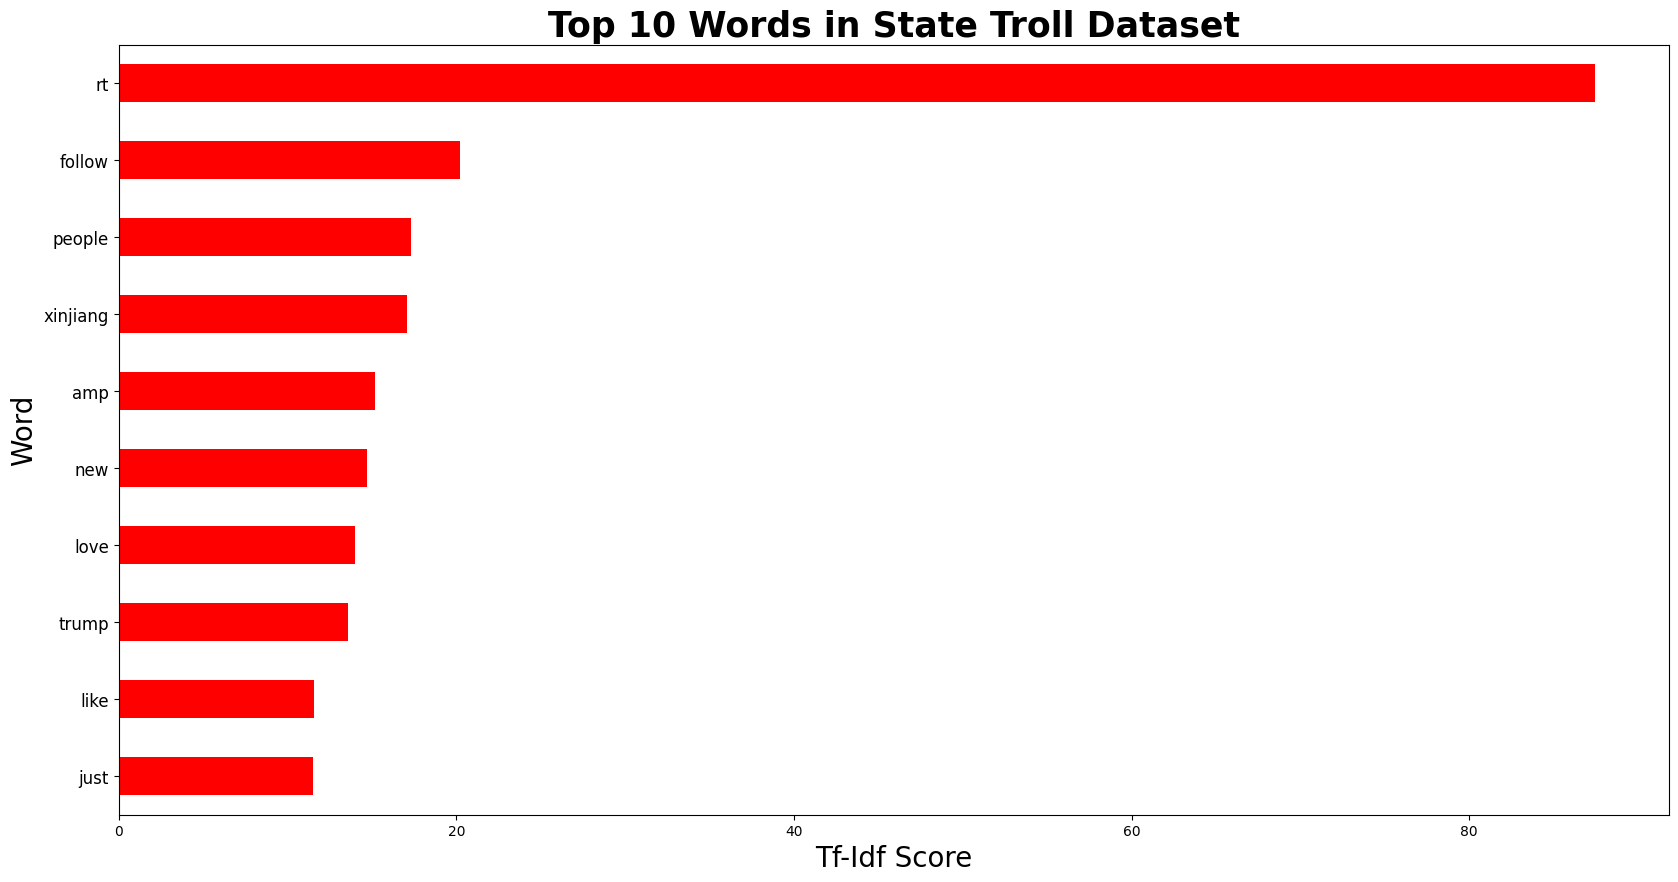

In [25]:
word_distribution(statetroll_tfidf_feq, 10, 'red', 1, (20, 10),
                  'Top 10 Words in State Troll Dataset',
                  'Tf-Idf Score',
                  'Word',
                  viz_path + '/state_word_distribution.png')

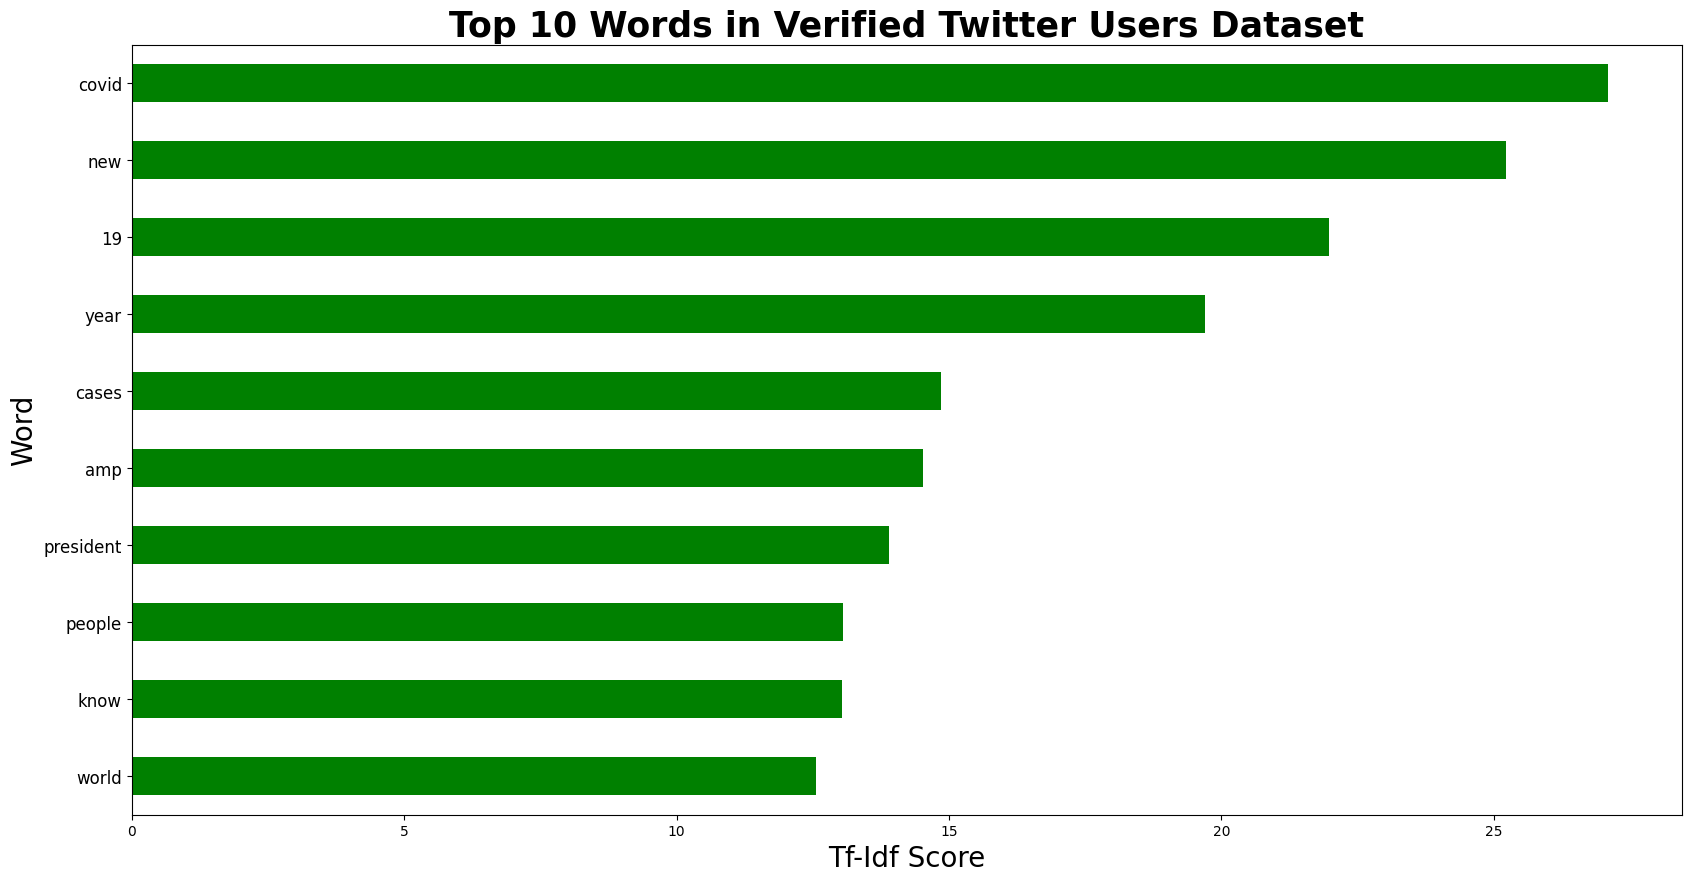

In [26]:
word_distribution(verified_tfidf_feq, 10, 'green', 2, (20, 10),
                  'Top 10 Words in Verified Twitter Users Dataset',
                  'Tf-Idf Score',
                  'Word',
                   viz_path + '/verified_word_distribution.png')


### Word Clouds

How we plot the word cloud associated with the state troll tweets

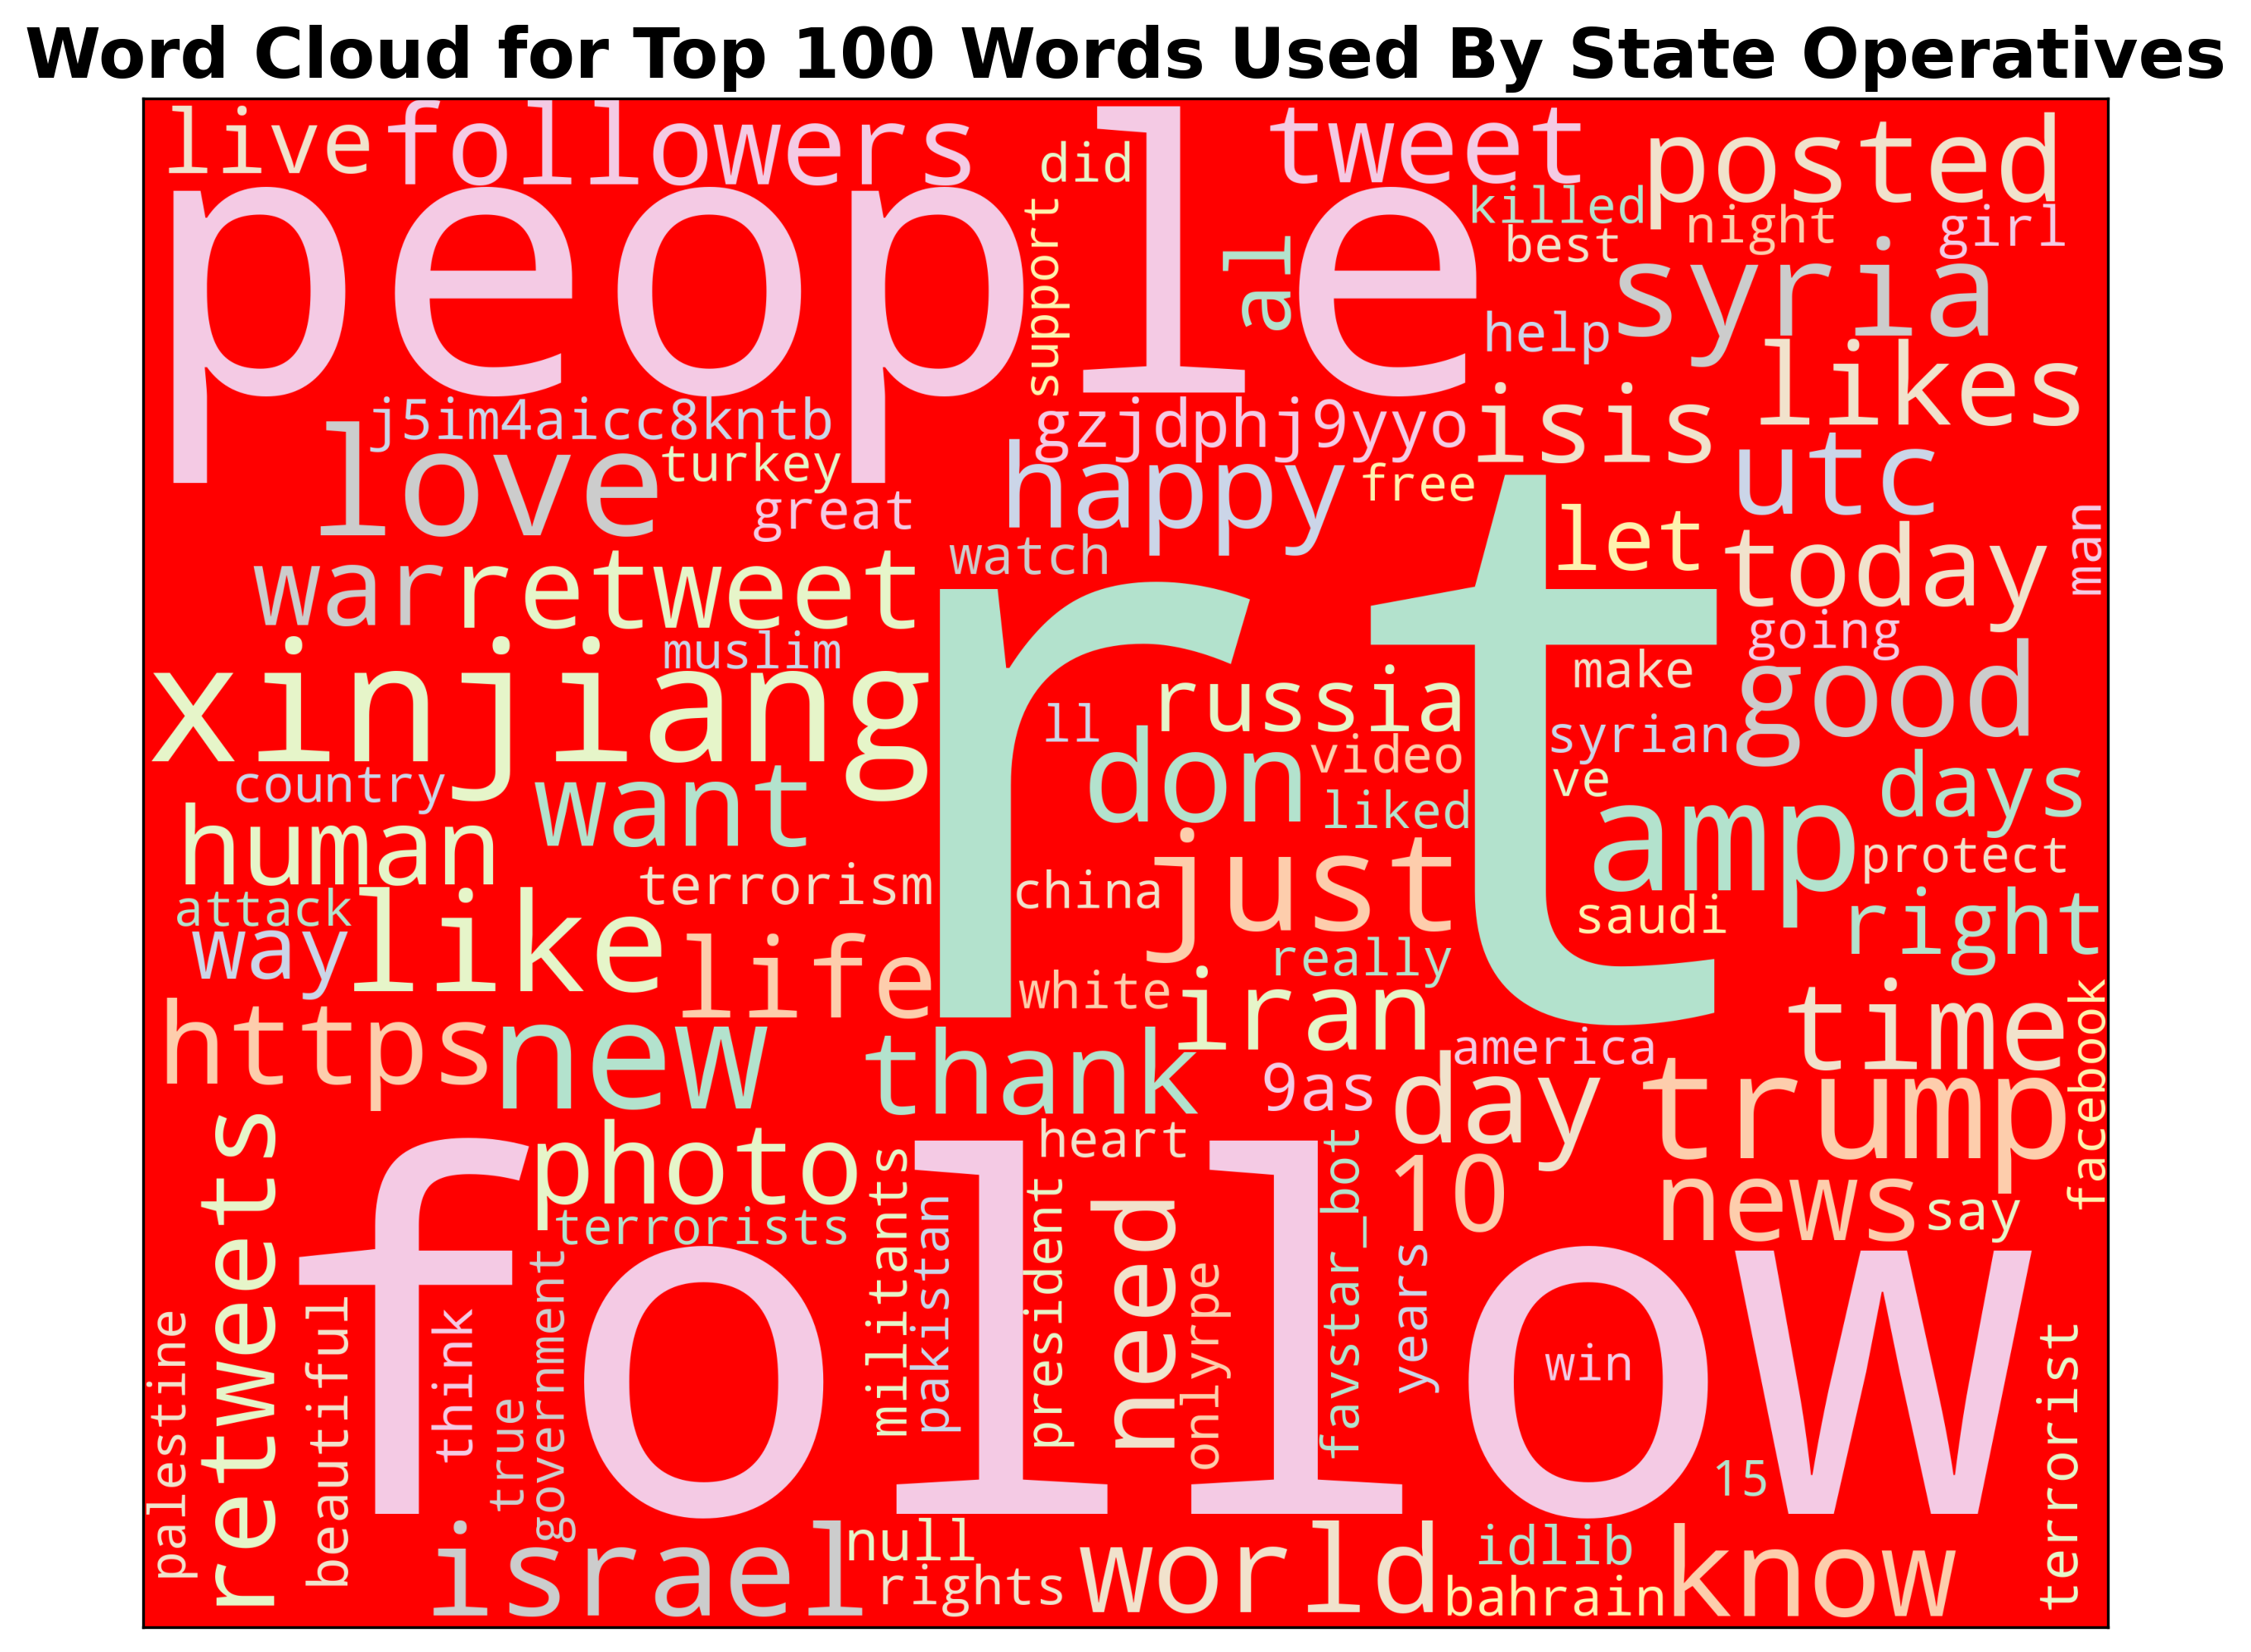

In [27]:
plot_wordcloud(statetroll_tfidf_feq, 'red', 'Pastel2', 100, 'Word Cloud for Top 100 Words Used By State Operatives', 3, 20, 8, viz_path + '/state_wordcloud.png')

Similarly, we generate the word cloud from the verified Twitter users

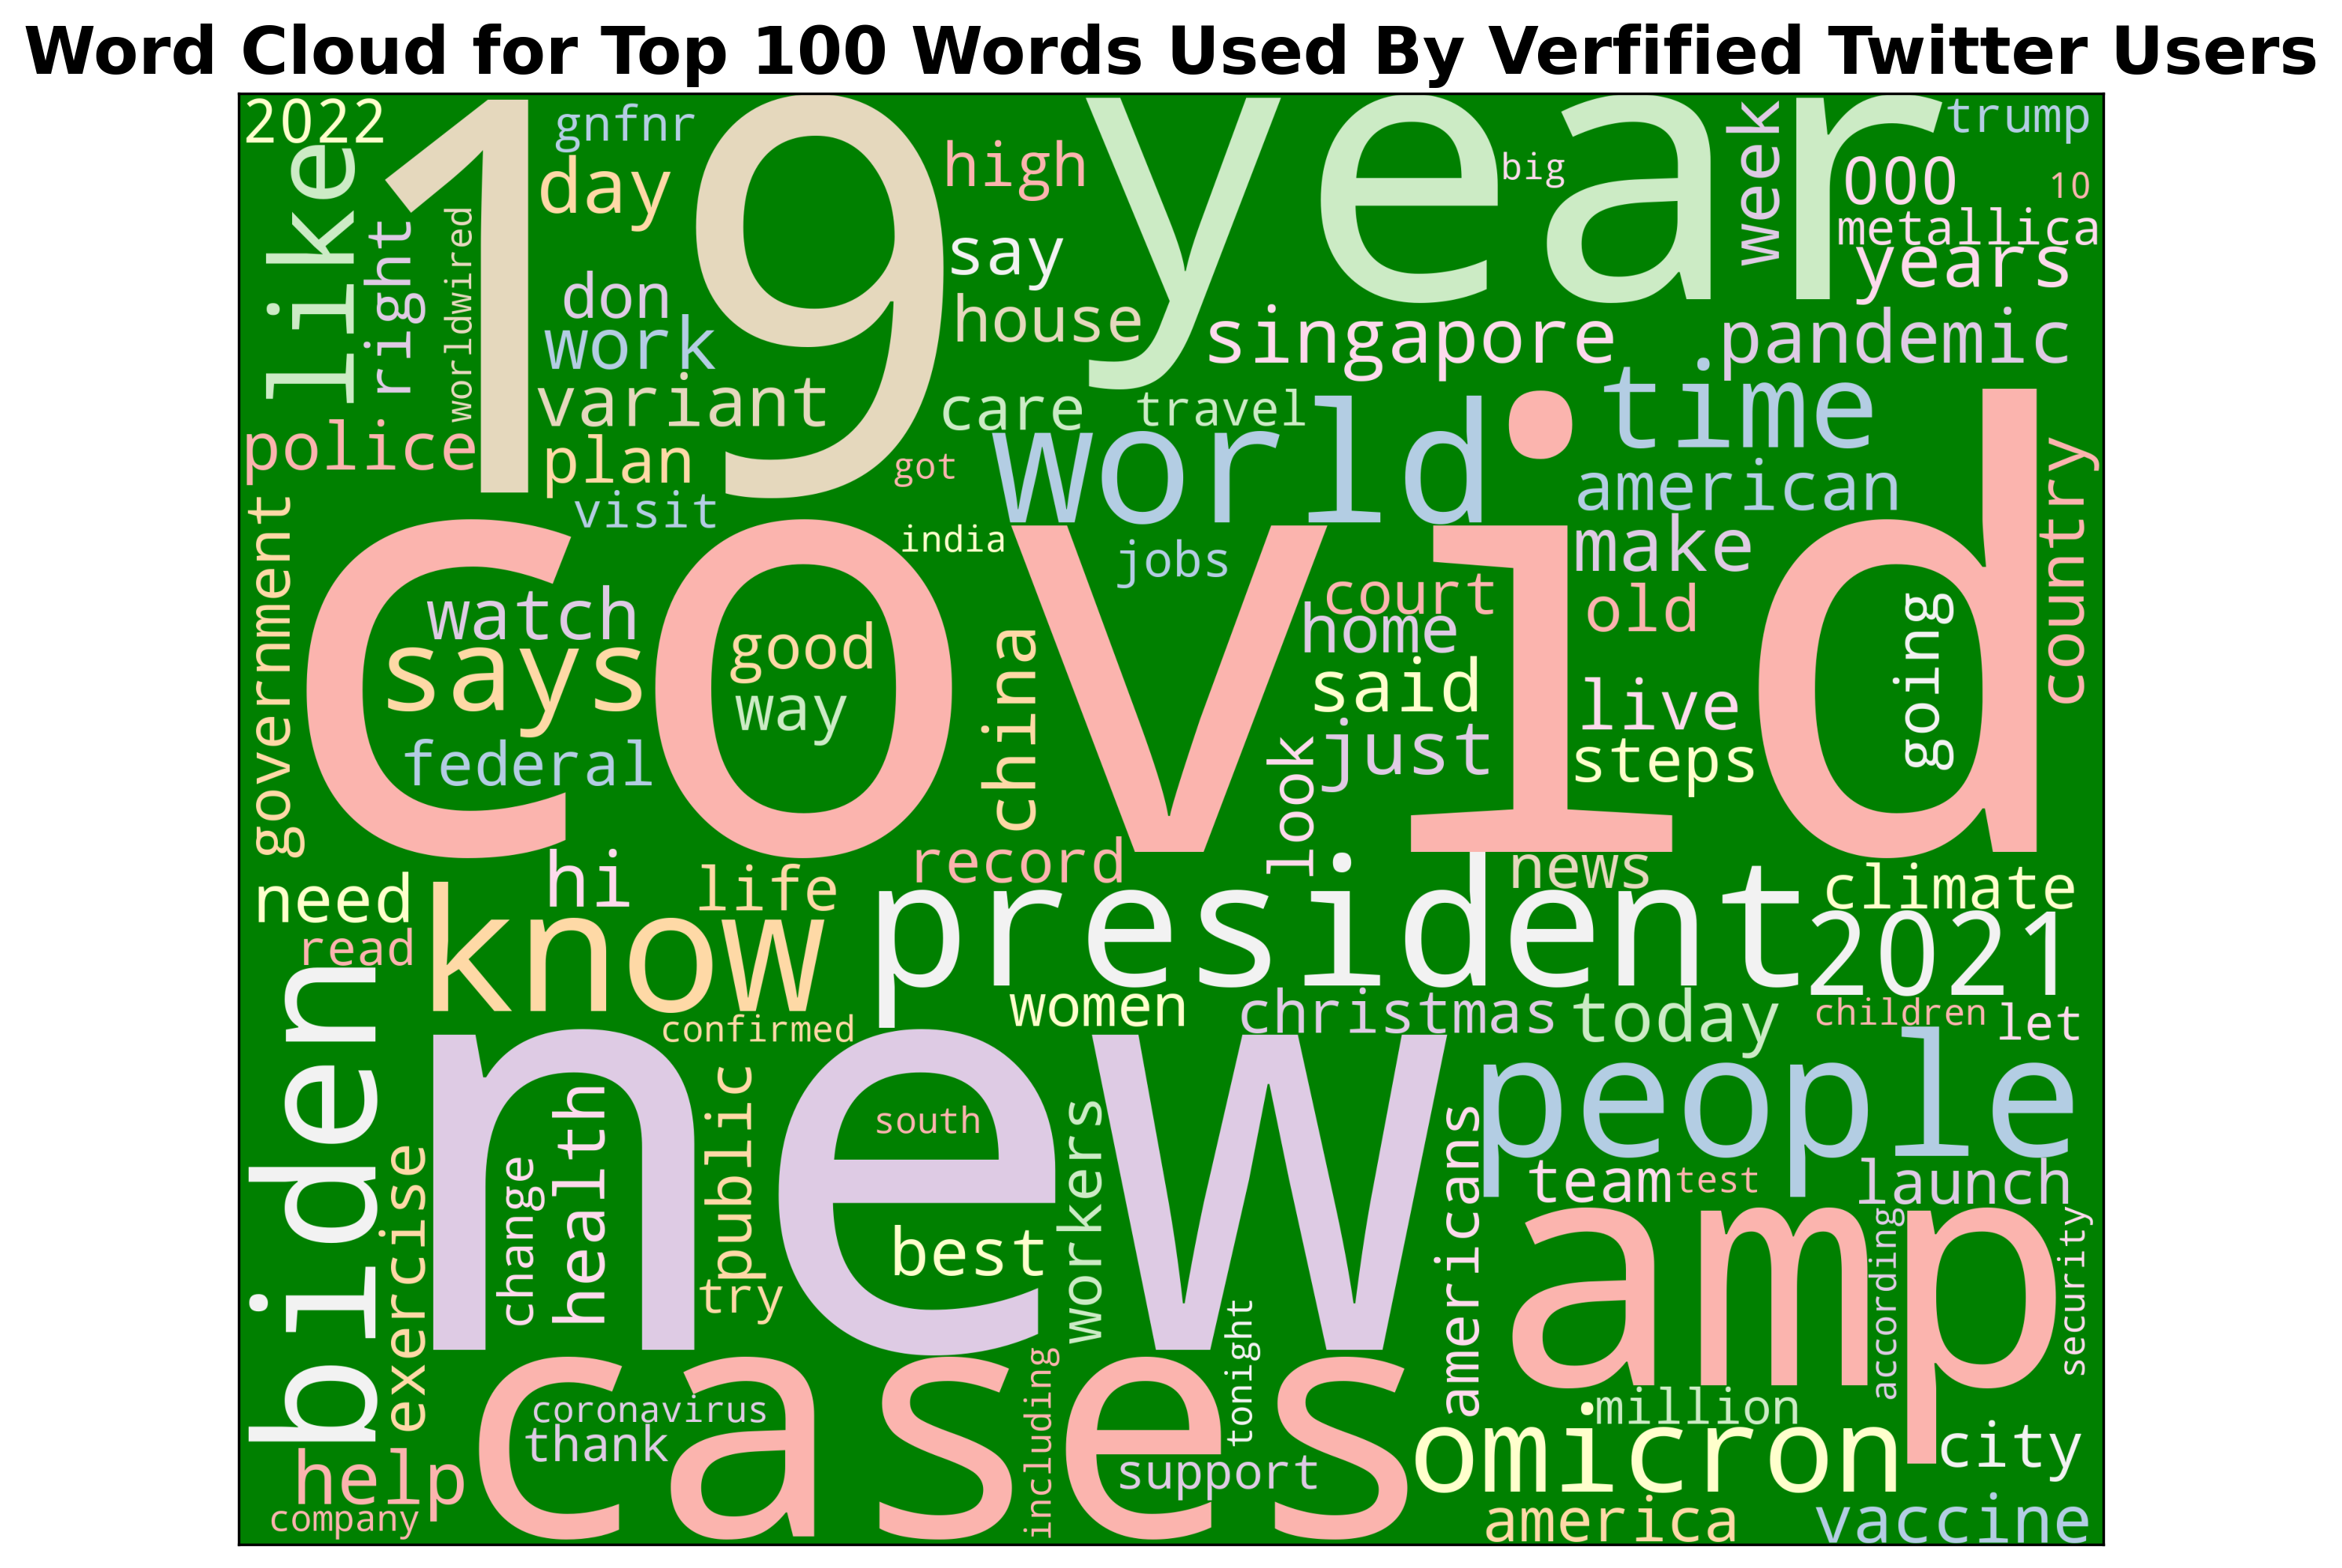

In [28]:
plot_wordcloud(verified_tfidf_feq, 'green', 'Pastel1', 100, 'Word Cloud for Top 100 Words Used By Verfified Twitter Users', 3, 20, 8, viz_path + '/verified_wordcloud.png')

### Kmeans Clustering Plots

We'll first fit the word encodings into the K-Means clusterer, and then plot the results. We would need to split the train dataframe into state troll and verified users

In [29]:
statetroll_feature_vectors = df_train[df_train['target'] == 1]['feature_vectors']
verified_feature_vectors  = df_train[df_train['target'] == 0]['feature_vectors']

# then, we squeeze the respective columns into a nd-array to be passed to Kmeans classifier later
# this is faster than vstacking them
statetroll_feature_vectors = np.array(statetroll_feature_vectors.values.tolist()).squeeze()
verified_feature_vectors = np.array(verified_feature_vectors.values.tolist()).squeeze()

In [30]:
statetroll_feature_vectors

array([[-0.40510723,  0.47039473,  0.47994724, ..., -0.4287756 ,
         0.48644903, -0.75200796],
       [-0.38649616,  0.49461144,  0.46277016, ..., -0.38185316,
         0.48978218, -0.57829064],
       [-0.38076538,  0.46476132,  0.45160156, ..., -0.39098367,
         0.48446566, -0.75923353],
       ...,
       [-0.35991088,  0.462665  ,  0.48665103, ..., -0.44939142,
         0.53695995, -0.6136615 ],
       [-0.45620805,  0.41035652,  0.5541255 , ..., -0.45053095,
         0.4930069 , -0.6376804 ],
       [-0.29725802,  0.42033762,  0.37767896, ..., -0.38950834,
         0.49508968, -0.7912934 ]], dtype=float32)

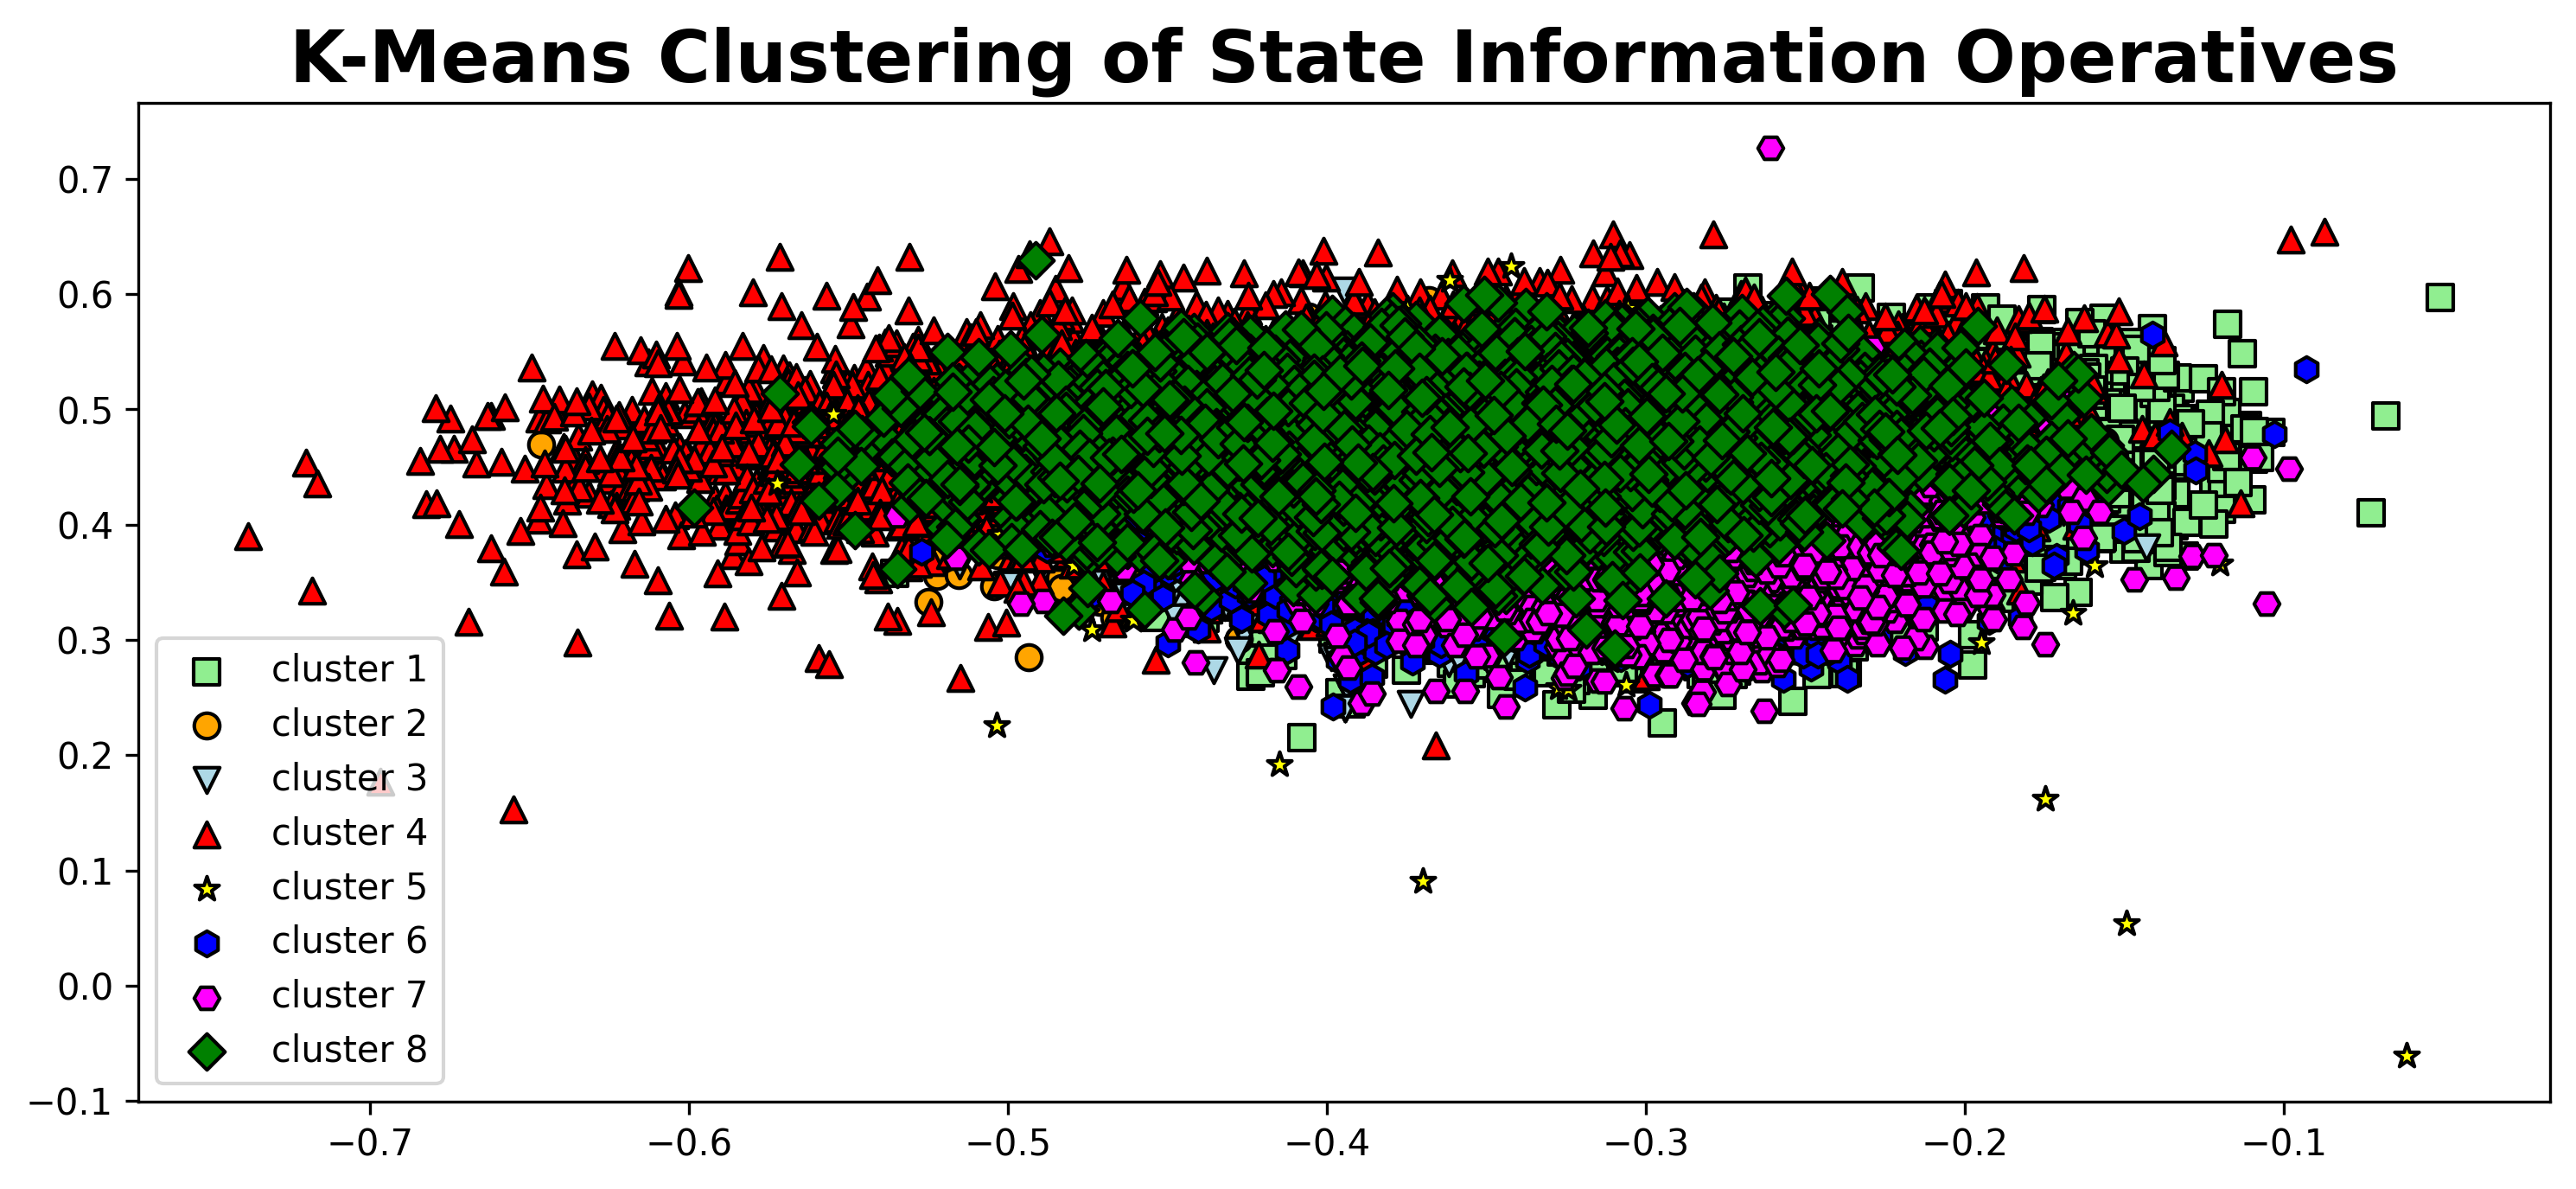

In [31]:
colors = ['lightgreen', 'orange', 'lightblue', 'red', 'yellow', 'blue', 'Magenta', 'green']
markers = ['s', 'o', 'v', '^', '*', 'h', 'H', 'D']
KMeans_plot(statetroll_feature_vectors, 8, colors, markers, 'K-Means Clustering of State Information Operatives', 5, 12, 5, viz_path + '/state_kmeans_clustering.png')

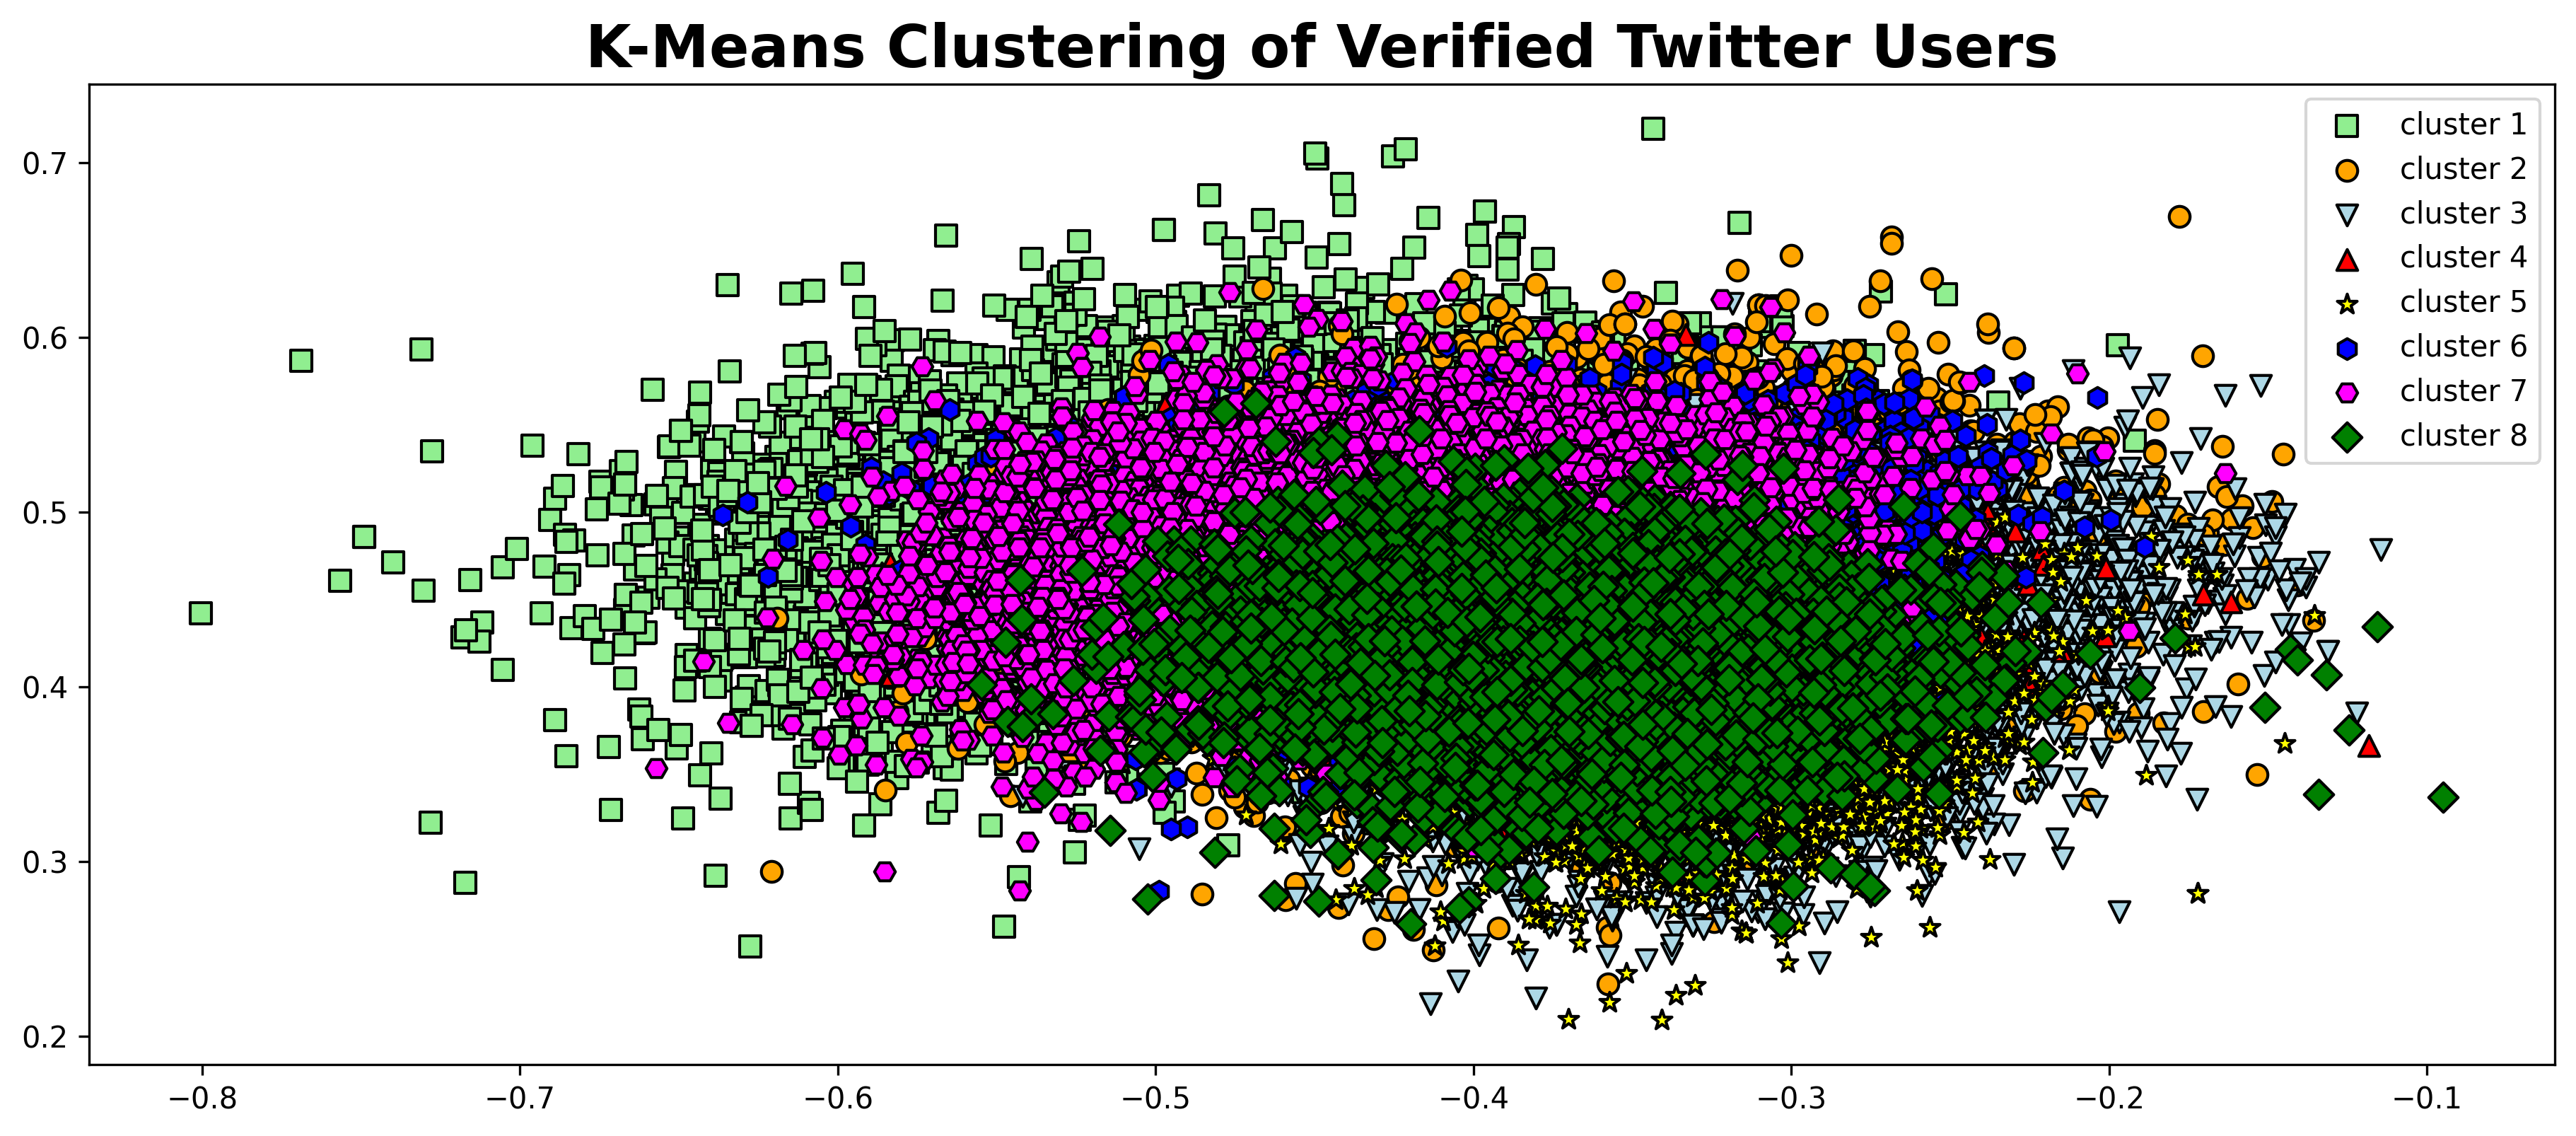

In [32]:
KMeans_plot(verified_feature_vectors, 8, colors, markers, 'K-Means Clustering of Verified Twitter Users', 5, 15, 6, viz_path + '/verified_kmeans_clustering.png')

### Topic Modelling Using BERTopic

We first split the test dataframe into the tweets made by trolls, and those made by verified users. We then pass the two seperate dataframes into the BERTopic model to get the topic numbers

In [ ]:
state_troll_df = df_train[df_train['target'] == 1]
verified_df   = df_train[df_train['target'] == 0]

In [ ]:
def create_wordcloud(topic_model, topic, i, width, height, save_name):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(width            = 1500,
                   height           = 1000,
                   background_color = "white",
                   max_words        = 500,
                   random_state     = 1)
    wc.generate_from_frequencies(text)

    mpp.figure(i, (width, height), dpi = 200)
    frame1 = mpp.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    mpp.imshow(wc, interpolation = 'bilinear')
    mpp.savefig(save_name, dpi = 200)
    mpp.axis('off')
    mpp.show()

In [ ]:
# set up model for state operatives and fit topics
topic_model_troll   = BERTopic(verbose = True)
topics_troll, probs = topic_model_troll.fit_transform(state_troll_df['clean_tweet_text'].to_list())

# set up the model for verified users and fit its topics
topic_model_verified   = BERTopic(verbose = True)
topics_verified, probs = topic_model_verified.fit_transform(verified_df['clean_tweet_text'].to_list())

2024-05-10 16:47:27,626 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2348 [00:00<?, ?it/s]

2024-05-10 16:48:05,244 - BERTopic - Embedding - Completed ✓
2024-05-10 16:48:05,245 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-10 16:50:36,722 - BERTopic - Dimensionality - Completed ✓
2024-05-10 16:50:36,727 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
2024-05-10 16:50:48,775 - BERTopic - Cluster - Completed ✓
2024-05-10 16:50:48,802 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-10 16:50:51,636 - BERTopic - Representation - Completed ✓
2024-05-10 16:50:54,116 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2341 [00:00<?, ?it/s]

2024-05-10 16:51:33,304 - BERTopic - Embedding - Completed ✓
2024-05-10 16:51:33,307 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-10 16:53:19,992 - BERTopic - Dimensionality - Completed ✓
2024-05-10 16:53:19,998 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-10 16:53:26,943 - BERTopic - Cluster - Completed ✓
2024-05-10 16:53:26,971 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-10 16:53:32,240 - BERTopic - Representation - Completed ✓


Show 30 word cloud for state operatives

In [ ]:
n_wc = 30

In [ ]:
for i in range(n_wc):
    wc_name = viz_path + f'/state_operative_topic_{i+1}.png'
    create_wordcloud(topic_model_troll, i, i, width = 15, height = 6, save_name = wc_name)

Output hidden; open in https://colab.research.google.com to view.

Similarly, for the verified users

In [ ]:
for i in range(n_wc):
    wc_name = viz_path + f'/verified_topic_{i+1}.png'
    create_wordcloud(topic_model_verified, i, i, width = 15, height = 6, save_name = wc_name)

Output hidden; open in https://colab.research.google.com to view.

## Conclusion

- SPOTTED performed very well as a fine-tuned pretrained model. The fact that all of the evaluation metrics of the model is more than 90%, shows that the model generalizes well to tweets that it has not seen before.

- The plots in the Data Visualization section showed that:
   - The tweets of the operatives revolves around a closely related topics and events, as seen by the KMeans clustering plot. On the other hand, the Kmeans clustering plot of the verified users are more dispersed. This is expected, as the operatives normally hyper-focus on a select set of events or topics to exploit, while the topics by the verified users have much more variety and scope.
   - The words that are used most frequently by the operatives are **"people"**, **"rt"** (which means retweet) and **"follow"**. This could meant that the operatives share and retweet tweets already made by other users (troll or not). The operatives also suggest users to follow other accounts, in a effort to expand the reach of the troll tweets. On the other hand, the top words used in the verified tweets are **"covid"**, **"19"**, **"new"**, **"cases"**. This is expected, as the COVID-19 pandemic was at its peak during early 2020 to late 2021, which was heavily reported by news and social media.
   - From the word cloud of the topics made by the operatives, we see clearly see their aim is to sow discord and exploit exising societal differences and tensions. Notably, we see words such as **"palestinewillbefree"**, **"educateyourselfonislam"**, **"blacklivesmatter"**, **"trumptrain"**. These topics are commonly associated islamophobia and racist in the US. Interestingly, the operatives also include references such as **"naughty"**, **"sex"**, **"basketball"**, this could also infer another tactic by the operatives to entice users to view their accounts and read their tweets, hence expanding their reach to an even wider audience
   - On the other hand, word cloud of the verified users contains words such as **"afghanistan"**, **ukraine"**,  **"coronavirus"**, **"sgelections"**, **"pfizer"**, **"lockdown"** - which refers to the 2021 US Afghanistan withdrawal, the COVID-19 pandemic and the race to find a vaccine for the virus.

---
## How Can Machine Learning / AI Assist Intelligence Gathering and Analysis?
---

This project demonstrated the application of using pretrained LLMs in OSINT analysis. We fine-tuned a pretrained LLM, using tweets made by state information operatives, and those made by verified users, the model can predict whether a unseen tweet is generated by a state operative or not. This ability to uncover trolls using AI can speed up the ability to quickly inform moderators to take these accounts down. Indeed, the broader field of AI and ML not restricted to NLP can greatly accelerate intelligence gathering and analysis via the following methods:

1. **_Increased efficiency:_** get rid of manual / laborous process / workflow which is error-prone. In the case of GEOINT, one can exploit geospatial ML packages to quickly generate polygons for feature extraction. This allow  Military Intelligence Analysts to move to quality control and assurance faster and deliver geospatial products in an accelerated pace.

2.  **_Increased accuracy:_** take the example of target recognition. We can use computer vision to train a model to identify different military hardware - tanks, fighter jets and aircrafts etc. This can help Air Imagery Intelligence Experts (AIRIX) in rapidly identifying targets.

3. **_Monitoring and Survellience:_** the data used in Project SPOTTED is static. We can further train the model with new tweets. In particular, we can use such a model to flag / identify suspicous accounts amplifying terroristic sentiments or emphatise with known terror groups. This will greatly help Military Intelligence Experts in rapidly identifying suspicious accounts, and alerting the appropriate authorities for further investigation and actions.